# Занятие 2 (14.11.2018)

**Сегодня мы научимся**:

* Обработке данных
* Подбору параметров с помощью кросс-валидации и встроенных методов SkLearn
* Визуализации данных с помощью t-SNE и метода главных компонент PCA. Изучим их плюсы и минусы

## Обработка данных

### Типы признаков

| Тип признака   | Количество возможных значений      |         Пример значений        | Пример признака                      |
|----------------|------------------------------------|:------------------------------:|--------------------------------------|
| Бинарные       | 2                                  |         [0, 1, 0, 0, 1]        | Пол, наличие задолженностей (да/нет) |
| Числовое       | Бесконечное (Непрерывная величина) |   [1.5, 2.1, 0.35464, -1.245]  | Рост, вес, цена                      |
| Категориальные | Конечное (Дискретная величина)     | [0, 1, 2, 3], ["Вася", "Петя"] | Имя, тип билета             |
| Порядковые     | Конечное (Имеющие порядок)         | [0, 1, 2], ["Омск", "Москва"]  | Образование, ближайшая ст. метро |


Большинство алгоритмов машинного обучения умеют работать только с числовыми и бинарными признаками. Поэтому дополнительной обработки требуют категориальные и  порядковые признаки.

Активно используются несколько подходов: 

1. Преобразовать в несколько бинарных признаков (aka One-Hot-Encoding)
2. Преобразовать в одну колонку числовых данных (aka Label Encoding, Target Encoding)
3. Преобразовать в вектор (Count Vectorizer, Word2Vec - что-то подобное используется в CatBoost)



# One-Hot-Encoding


![](https://i.imgur.com/mtimFxh.png)


В pandas'e уже есть реализованный функционал. Чтобы проверить, как он работает, давайте загрузим датасет с категориальными признаками.

In [1]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/ismayc/pnwflights14/master/data/flights.csv')
df.head() # выводит первые 5 (по умолчанию) строчек таблицы

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute
0,2014,1,1,1.0,96.0,235.0,70.0,AS,N508AS,145,PDX,ANC,194.0,1542,0.0,1.0
1,2014,1,1,4.0,-6.0,738.0,-23.0,US,N195UW,1830,SEA,CLT,252.0,2279,0.0,4.0
2,2014,1,1,8.0,13.0,548.0,-4.0,UA,N37422,1609,PDX,IAH,201.0,1825,0.0,8.0
3,2014,1,1,28.0,-2.0,800.0,-23.0,US,N547UW,466,PDX,CLT,251.0,2282,0.0,28.0
4,2014,1,1,34.0,44.0,325.0,43.0,AS,N762AS,121,SEA,ANC,201.0,1448,0.0,34.0


year, month, day - Date of departure

dep_time, arr_time - Actual departure and arrival times (format HHMM or HMM), local tz.

dep_delay, arr_delay - Departure  and  arrival  delays,  in  minutes.   Negative  times  represent  early
departures/arrivals.

hour,minute - Time of scheduled departure broken into hour and minutes.

carrier - Two letter carrier abbreviation. 

tailnum - Plane tail number

flight - Flight number

origin,dest - Origin and destination. 

air_time - Amount of time spent in the air, in minutes

distance - Distance between airports, in miles

* Метод pd.get_dummies() найдёт и преобразует все колонки с типом 'category' и 'object' в вашем датасете. 
* Можно указать отедльные колонки в параметре pd.get_dummies(df, columns=['cat_feat_1', 'cat_feat_2'])
* Параметр drop_first=True позволит избежать мультиколлениарности в данных.
* Мультиколлинеарность — тесная корреляционная взаимосвязь между отбираемыми для анализа факторами, совместно воздействующими на общий результат, которая затрудняет оценивание регрессионных параметров.
* Для линейных моделей мультиколлениарность страшна, так как может вести к нестабильным и сильно вариативным решениям.
* Для остальных моделей — бессмысленно увеличивать признаковое пространство, снижать скорость обучения и мешать интерпретируемости.
* При высокой корреляции таких признаков с таргетом, возможно, и не стоит их выкидывать.

Сделаем автоматический One-Hot-Encoding всех колонок.

In [2]:
df_proc = pd.get_dummies(df, drop_first=True) 
df_proc.head()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,flight,air_time,distance,...,dest_SEA,dest_SFO,dest_SIT,dest_SJC,dest_SLC,dest_SMF,dest_SNA,dest_STL,dest_TPA,dest_TUS
0,2014,1,1,1.0,96.0,235.0,70.0,145,194.0,1542,...,0,0,0,0,0,0,0,0,0,0
1,2014,1,1,4.0,-6.0,738.0,-23.0,1830,252.0,2279,...,0,0,0,0,0,0,0,0,0,0
2,2014,1,1,8.0,13.0,548.0,-4.0,1609,201.0,1825,...,0,0,0,0,0,0,0,0,0,0
3,2014,1,1,28.0,-2.0,800.0,-23.0,466,251.0,2282,...,0,0,0,0,0,0,0,0,0,0
4,2014,1,1,34.0,44.0,325.0,43.0,121,201.0,1448,...,0,0,0,0,0,0,0,0,0,0


Сделаем One-Hot-Encoding только нужных колонок

In [3]:
df_proc = pd.get_dummies(df, columns=['dest', 'carrier']) 
df_proc.head()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,tailnum,flight,origin,...,carrier_AS,carrier_B6,carrier_DL,carrier_F9,carrier_HA,carrier_OO,carrier_UA,carrier_US,carrier_VX,carrier_WN
0,2014,1,1,1.0,96.0,235.0,70.0,N508AS,145,PDX,...,1,0,0,0,0,0,0,0,0,0
1,2014,1,1,4.0,-6.0,738.0,-23.0,N195UW,1830,SEA,...,0,0,0,0,0,0,0,1,0,0
2,2014,1,1,8.0,13.0,548.0,-4.0,N37422,1609,PDX,...,0,0,0,0,0,0,1,0,0,0
3,2014,1,1,28.0,-2.0,800.0,-23.0,N547UW,466,PDX,...,0,0,0,0,0,0,0,1,0,0
4,2014,1,1,34.0,44.0,325.0,43.0,N762AS,121,SEA,...,1,0,0,0,0,0,0,0,0,0


# Label Encoding
Label Encoding позволяет преобразовать категориальный признак в одну колонку числовых данных.


In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/ismayc/pnwflights14/master/data/flights.csv')
df.head()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute
0,2014,1,1,1.0,96.0,235.0,70.0,AS,N508AS,145,PDX,ANC,194.0,1542,0.0,1.0
1,2014,1,1,4.0,-6.0,738.0,-23.0,US,N195UW,1830,SEA,CLT,252.0,2279,0.0,4.0
2,2014,1,1,8.0,13.0,548.0,-4.0,UA,N37422,1609,PDX,IAH,201.0,1825,0.0,8.0
3,2014,1,1,28.0,-2.0,800.0,-23.0,US,N547UW,466,PDX,CLT,251.0,2282,0.0,28.0
4,2014,1,1,34.0,44.0,325.0,43.0,AS,N762AS,121,SEA,ANC,201.0,1448,0.0,34.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162049 entries, 0 to 162048
Data columns (total 16 columns):
year         162049 non-null int64
month        162049 non-null int64
day          162049 non-null int64
dep_time     161192 non-null float64
dep_delay    161192 non-null float64
arr_time     161061 non-null float64
arr_delay    160748 non-null float64
carrier      162049 non-null object
tailnum      161801 non-null object
flight       162049 non-null int64
origin       162049 non-null object
dest         162049 non-null object
air_time     160748 non-null float64
distance     162049 non-null int64
hour         161192 non-null float64
minute       161192 non-null float64
dtypes: float64(7), int64(5), object(4)
memory usage: 19.8+ MB


In [6]:
for col in df.columns:
    if df[col].dtype=='object':
        print('{:8}: {:4} in {}'.format(col, df[col].nunique(), df.shape[0]))

carrier :   11 in 162049
tailnum : 3022 in 162049
origin  :    2 in 162049
dest    :   71 in 162049


In [7]:
cat_cols = [col for col in df.columns if df[col].dtype=='object'
            and df[col].nunique() < 100]

cat_cols

['carrier', 'origin', 'dest']

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [10]:
df.head()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute
0,2014,1,1,1.0,96.0,235.0,70.0,1,N508AS,145,0,1,194.0,1542,0.0,1.0
1,2014,1,1,4.0,-6.0,738.0,-23.0,8,N195UW,1830,1,12,252.0,2279,0.0,4.0
2,2014,1,1,8.0,13.0,548.0,-4.0,7,N37422,1609,0,29,201.0,1825,0.0,8.0
3,2014,1,1,28.0,-2.0,800.0,-23.0,8,N547UW,466,0,12,251.0,2282,0.0,28.0
4,2014,1,1,34.0,44.0,325.0,43.0,1,N762AS,121,1,1,201.0,1448,0.0,34.0


* Для линейных моделей предпочтительнее использовать OHE (учитывая мультиколлениарность). Так как в Label Encoding лин модели будут искать зависимости между значениями, которых нет. Если, например, закодировать `['red', 'green', 'red', 'blue']` числами -> `['1', '2', '1', '3']`, то лин модели будут думать, что синий больше зеленого, а зеленый больше красного, что смысла не имеет.
* Логические модели не имеют такого свойства, поэтому искать подобный смысл в числах не будут. Зато они могут быть чувствительны к размеру признакового пространства, поэтому Label Encoding для них предпочтительнее.
* Метрические методы также чувствительны к размеру признакового пространства, поэтому Label Encoding и для них предпочтительнее.

# Пропущенные значения

In [11]:
df.isnull().sum()

year            0
month           0
day             0
dep_time      857
dep_delay     857
arr_time      988
arr_delay    1301
carrier         0
tailnum       248
flight          0
origin          0
dest            0
air_time     1301
distance        0
hour          857
minute        857
dtype: int64

Есть несколько способов бороться с пропусками в данных:
* Если их слишком много, то можно удалить всю колонку;
* Можно сделать бинарную колонку, где 1 - это пропуски в исследуемой колонке и 0 - заполненные значения;
* Для категориальных данных пропуски можно заполнить одним отличным ото всех значением и создать новую категорию таким образом;
* Для числовых значений пропуски можно заполнить средним, медианной, модой (линейные модели);
* Для числовых значений пропуски можно заполнить отличным ото всех значением, например, -999 для колонки возраста (логические модели);
* Можно поступать хитрее и, например, заполнять числовые признаки средними с учетом других категорий, но для этого должно быть понимание предметной области.

In [12]:
# бинарная колонка
df['arr_delay_nans'] = df['arr_delay'].isnull() * 1
df[['arr_delay', 'arr_delay_nans']].head()

,arr_delay,arr_delay_nans
0,70.0,0
1,-23.0,0
2,-4.0,0
3,-23.0,0
4,43.0,0


In [13]:
df[df['arr_delay'].isnull()][['arr_delay', 'arr_delay_nans']].head()

,arr_delay,arr_delay_nans
408,NaN,1
409,NaN,1
410,NaN,1
411,NaN,1
412,NaN,1


In [14]:
# категориальные данные
df['tailnum'].fillna('Nonetype', inplace=True)
df[df['tailnum']=='Nonetype'].head()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute,arr_delay_nans
416,2014,1,1,NaN,NaN,NaN,NaN,7,Nonetype,1142,1,20,NaN,2402,NaN,NaN,1
417,2014,1,1,NaN,NaN,NaN,NaN,7,Nonetype,1195,1,16,NaN,1024,NaN,NaN,1
418,2014,1,1,NaN,NaN,NaN,NaN,7,Nonetype,1647,0,51,NaN,1739,NaN,NaN,1
870,2014,1,2,NaN,NaN,NaN,NaN,7,Nonetype,212,1,20,NaN,2402,NaN,NaN,1
871,2014,1,2,NaN,NaN,NaN,NaN,7,Nonetype,583,0,20,NaN,2434,NaN,NaN,1


In [15]:
# среднее и -999
df['dep_time'].fillna(df['dep_time'].mean(), inplace=True)
df['dep_delay'].fillna(-999, inplace=True)

df[df['tailnum']=='Nonetype'][['dep_time', 'dep_delay']].head()

,dep_time,dep_delay
416,1278.283755,-999.0
417,1278.283755,-999.0
418,1278.283755,-999.0
870,1278.283755,-999.0
871,1278.283755,-999.0


In [16]:
# с учетом других категорий
for val in df['origin'].unique():
    df.loc[df['origin']==val, 'arr_time'] = df[df['origin']==val]['arr_time'].mean()

In [17]:
df[df['tailnum']=='Nonetype'].head()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute,arr_delay_nans
416,2014,1,1,1278.283755,-999.0,1491.948127,NaN,7,Nonetype,1142,1,20,NaN,2402,NaN,NaN,1
417,2014,1,1,1278.283755,-999.0,1491.948127,NaN,7,Nonetype,1195,1,16,NaN,1024,NaN,NaN,1
418,2014,1,1,1278.283755,-999.0,1463.193034,NaN,7,Nonetype,1647,0,51,NaN,1739,NaN,NaN,1
870,2014,1,2,1278.283755,-999.0,1491.948127,NaN,7,Nonetype,212,1,20,NaN,2402,NaN,NaN,1
871,2014,1,2,1278.283755,-999.0,1463.193034,NaN,7,Nonetype,583,0,20,NaN,2434,NaN,NaN,1


# Скалирование признаков

Скалирование признаков необходимо использовать там, где это требуется алгоритмами.
* Для логических моделей, в принципе, скалирование признаков не нужно. 
* Для метрических моделей обязательно приведение признаков в один диапазон (чаще всего [0, 1] - MinMaxScaler). Это обусловлено тем, что метрические методы чувствительны к расстояниям.
* Обычная линейная и логистическая регрессии зачастую не нуждаются в скалировании, но ситуация меняется, когда мы добавляем регурялизацию. Тогда нам необходимо использовать StandardScaler.
* PCA (Principal component analysis), то есть метод, который базируется на анализе вариации, также нуждается в скалировании (StandardScaler), иначе будет плохо работать только из-за природы самих данных.
* Градиентный спуск может быстрее работать с признаками, чьи значения находятся в малых пределах (MinMaxScaler).
* Для линейных моделей бывает полезно логарифмировать таргет, чтобы восстановить его нормальность.
* С помощью скалирования можно невелировать влияние выбросов: логарифмирование, квадратный корень.

### Общее правило такое: если ваш алгоритм подразумевает расстояния или нормальность, то стоит использовать скалирование.

StandardScaler - вычитаем среднее и делим на стандартное отклонение:
![](https://cdn-images-1.medium.com/max/800/1*LysCPCvg0AzQenGoarL_hQ.png)

MinMaxScaler - вычитаем минимальное значение и делим на разность максимального с минимальным:
![](https://cdn-images-1.medium.com/max/800/1*19hq_t_NFQ6YVxMxsT0Cqg.png)

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

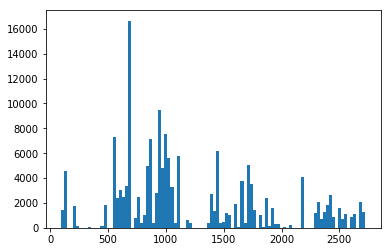

In [19]:
plt.hist(df['distance'], bins=100)
plt.show()

In [20]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

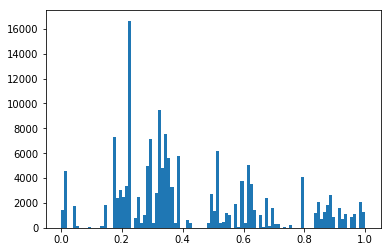

In [21]:
mms = MinMaxScaler()
df['distance_mms'] = mms.fit_transform(df[['distance']])
plt.hist(df['distance_mms'], bins=100)
plt.show()

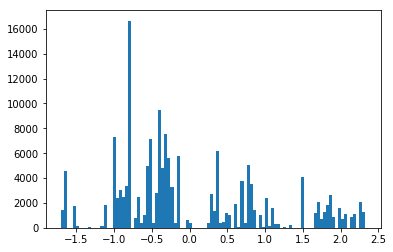

In [22]:
ss = StandardScaler()
df['distance_ss'] = ss.fit_transform(df[['distance']])
plt.hist(df['distance_ss'], bins=100)
plt.show()

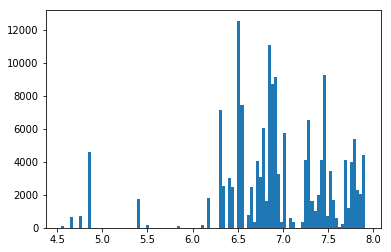

In [23]:
from math import log1p
df['distance_log'] = df['distance'].apply(log1p)
plt.hist(df['distance_log'], bins=100)
plt.show()

## Подбор параметров. Кросс-валидация 

Загрузите данные Ирис, как в прошлом [семинаре](Lesson_1.ipynb)

In [34]:
import seaborn as sns # библиотека для визуализации
df = sns.load_dataset("iris") # в seaborn и sklearn iris dataset идёт из коробки

Обозначим матрицу объект-признак и целевую переменную (species)

In [35]:
X = df.drop('species', 1) # возьмём в качестве объектов и признаков всё кроме колонки "species" (вид, разновидность цвета). 
# Метод .drop() выкидывает колонку "species". Если бы было .drop('species', 0), то выкинулась бы строка "species" 
y = df['species'] # в качестве целевой переменной возьмём вид цветка ("species")

Разобьём на обучающую и тестовую выборки

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777) # разобьём выборку на обучающую и на тестовую (80% данных на обучение)

Давайте теперь найдём наилучшие параметры для метода ближайших соседей для этой задачи

На прошлом семинаре вы могли увидеть, как "скачет" качество алгоритма от раза к разу. Давайте посмотрим более правильный подход оценки качества, который поможет нам подобрать наилучшие гиперпараметры модели и оценить её качество. Этот подход называется кросс-валидацией
![](https://kevinzakka.github.io/assets/k_fold_cv.jpg)
Как он работает? Всё просто! Мы бьём *один раз* всю нашу обучающую выборку случайным образом на K частей, далее на K - 1 части обучаемся, на 1 - тестируем. Так делаем для всех K частей и усредняем результат. Этот результат будет более состоятельной оценкой качества модели при данных гиперпараметрах

Попробуем теперь подобрать наилучшие параметры с помощью уже реализованного в SkLearn механизма кросс-валидации

In [47]:
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

base_clf = KNeighborsClassifier() # инициализируем базовый классификатор

params_grid = {
    'n_neighbors': list(range(1,50,2)), # Перебираем от 1 до 100 с шагом 2
    'weights': ['uniform', 'distance', lambda x: 1./x**2], # с каким весом берём каждого соседа. uniform - с одинаковым, distance - обратно пропорционально расстоянию. Ещё можно передать свою функцию
    'algorithm': ['auto'], # алгоритм поиска ближайших соседей. Влияет только на скорость обучения
    'leaf_size': [30], # параметры некоторых алгоритмов поиска ближ соседей. Влияет только на скорость обучения
    'metric': ['minkowski'], # метрика расстояния, используемая в алгоритме поиска ближайших соседей
    'p': [2] # параметр метрики, используемой в методе ближайших соседей 
}
gs = GridSearchCV(base_clf, params_grid, scoring='accuracy', cv=5) # cv - количество частей (K из рис. выше), verbose - выводить параметры во время обучения

gs.fit(X_train, y_train)

/home/myltykritik/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/myltykritik/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/myltykritik/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/myltykritik/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/myltykritik/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/myltykritik/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ =

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49], 'weights': ['uniform', 'distance', <function <lambda> at 0x7fa86263b268>], 'algorithm': ['auto'], 'leaf_size': [30], 'metric': ['minkowski'], 'p': [2]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

После вызова метода gs.fit() для базового классификатора автоматически подберутся наилучшие гиперпараметры

In [48]:
gs.best_score_ # наилучшее значение метрики (переменная best_acc из предыдущего семинара)

0.975

In [49]:
gs.best_params_ # наилучшие гиперпараметры

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'n_neighbors': 9,
 'p': 2,
 'weights': 'uniform'}

In [50]:
clf = gs.best_estimator_ # наилучший классификатор

## Задание
проверьте качество (accuracy) наилучшего классификатора на тестовой выборке

In [51]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9666666666666667

## Визуализация
Seaborn - отличный инструмент визуализации с большой [галереей](http://seaborn.pydata.org/examples/index.html) примеров

Прежде чем приступать к визуализации - всегда посмотрите на прочитанные данные

In [14]:
# df.head(100) # первые 100 строк
df.head() # выведем первые 5 строк таблицы

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


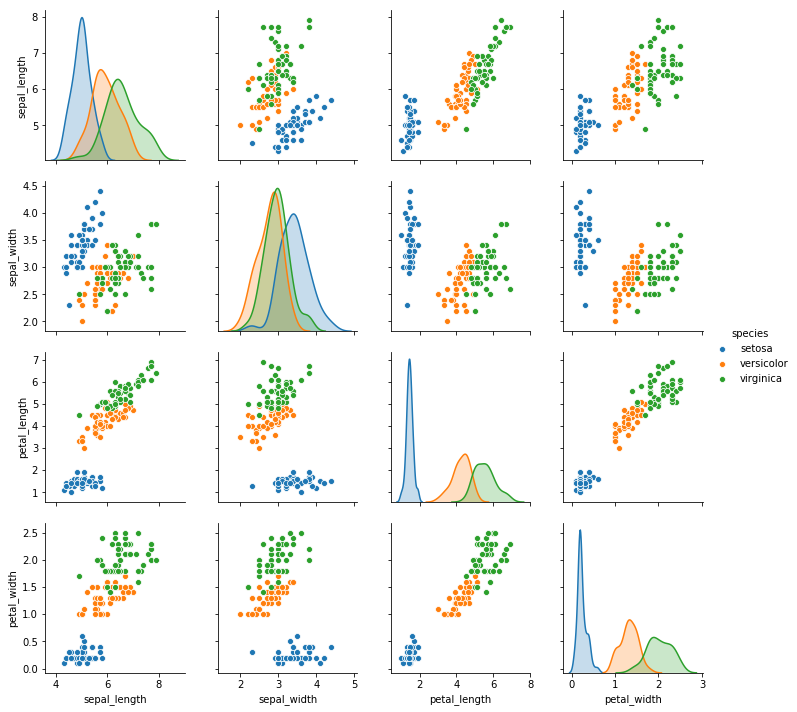

In [15]:
%matplotlib inline 
# %matplotlib inline - директива jupyter, которая позволяет рисовать графики в jupyter notebook
sns.pairplot(df, 'species') # диагональные элементы - гистограммы

# Визуализация сложных данных. t-SNE
![](https://d3ansictanv2wj.cloudfront.net/images/animation-94a2c1ff.gif)

In [34]:
import pandas as pd
data = pd.read_csv('https://raw.githubusercontent.com/gastonstat/CreditScoring/master/CreditScoring.csv')

1 Status -	credit status

2 Seniority -	job seniority (years)

3 Home -	type of home ownership

4 Time -	time of requested loan

5 Age -	client's age

6 Marital -	marital status

7 Records -	existance of records

8 Job -	type of job

9 Expenses -	amount of expenses

10 Income -	amount of income

11 Assets -	amount of assets

12 Debt -	amount of debt

13 Amount -	amount requested of loan

14 Price -	price of good

In [35]:
print(data['Status'].value_counts())
data = data[data['Status'] > 0] # Status = 0 - шум

1    3200
2    1254
0       1
Name: Status, dtype: int64


In [36]:
data = pd.get_dummies(data, columns=['Home', 'Job', 'Marital']) # One-Hot encoding


In [37]:
for col in data.drop('Status', 1).columns:
    ss = StandardScaler()
    data[col] = ss.fit_transform(data[[col]])

In [38]:
X, y = data.drop('Status', 1), data['Status']
print(X.shape, y.shape)
X.head()

(4454, 28) (4454,)


,Seniority,Time,Age,Records,Expenses,Income,Assets,Debt,Amount,Price,...,Job_1,Job_2,Job_3,Job_4,Marital_0,Marital_1,Marital_2,Marital_3,Marital_4,Marital_5
0,0.123969,0.925444,-0.644646,-0.458255,0.893055,-0.087706,-0.103800,-0.063754,-0.503524,-0.982044,...,-1.304236,-0.336071,1.830194,-0.199813,-0.014986,-0.530084,0.611774,-0.123582,-0.173392,-0.092764
1,1.102755,0.925444,1.904664,-0.458255,-0.388113,-0.087706,-0.103800,-0.063754,-0.082021,0.310831,...,0.766733,-0.336071,-0.546390,-0.199813,-0.014986,-0.530084,-1.634591,8.091824,-0.173392,-0.092764
2,0.246317,-0.712354,0.812103,2.182193,1.764250,-0.087698,-0.103506,-0.063754,2.025493,2.423695,...,-1.304236,-0.336071,1.830194,-0.199813,-0.014986,-0.530084,0.611774,-0.123582,-0.173392,-0.092764
3,-0.977166,0.925444,-1.190926,-0.458255,0.380588,-0.087700,-0.103555,-0.063754,-0.292772,-0.219375,...,0.766733,-0.336071,-0.546390,-0.199813,-0.014986,1.886492,-1.634591,-0.123582,-0.173392,-0.092764
4,-0.977166,-0.712354,-1.008833,-0.458255,-0.490606,-0.087709,-0.103800,-0.063754,-1.536205,-0.880143,...,0.766733,-0.336071,-0.546390,-0.199813,-0.014986,1.886492,-1.634591,-0.123582,-0.173392,-0.092764


Такие данные не визуализируешь ... Но есть t-SNE! ОООЧЕНЬ долго работающий на больших данных, но у нас, к счастью, данных не так немного

In [39]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X)

In [40]:
X_embedded.shape

(4454, 2)

Всё сжалось до 2 признаков

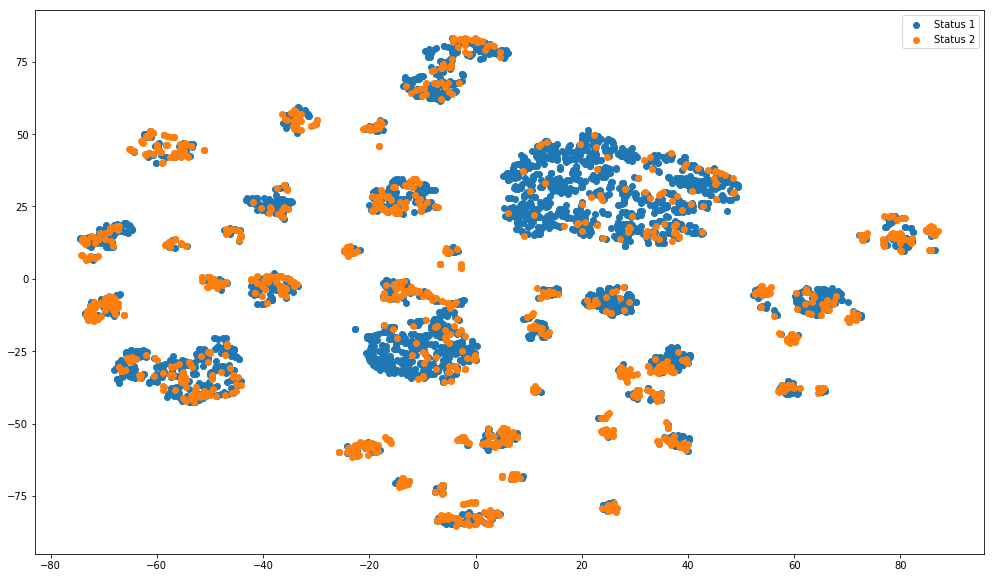

In [41]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.figure(figsize=(17,10))
zeros_idx = np.argwhere(y == 1).squeeze() # номера тех объектов, чей статус 1
ones_idx = np.argwhere(y == 2).squeeze() # номера тех объектов, чей статус 2
plt.scatter(X_embedded[zeros_idx, 0], X_embedded[zeros_idx, 1], label='Status 1')
plt.scatter(X_embedded[ones_idx, 0], X_embedded[ones_idx, 1], label='Status 2')
plt.legend()

Применим классификацию

In [42]:
for col in X.columns:
    mms = MinMaxScaler()
    X[col] = mms.fit_transform(X[[col]])

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
X_emb_train, X_emb_test, X_train,\
X_test, y_train, y_test = train_test_split(X_embedded, X, y, test_size=0.2, random_state=777)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

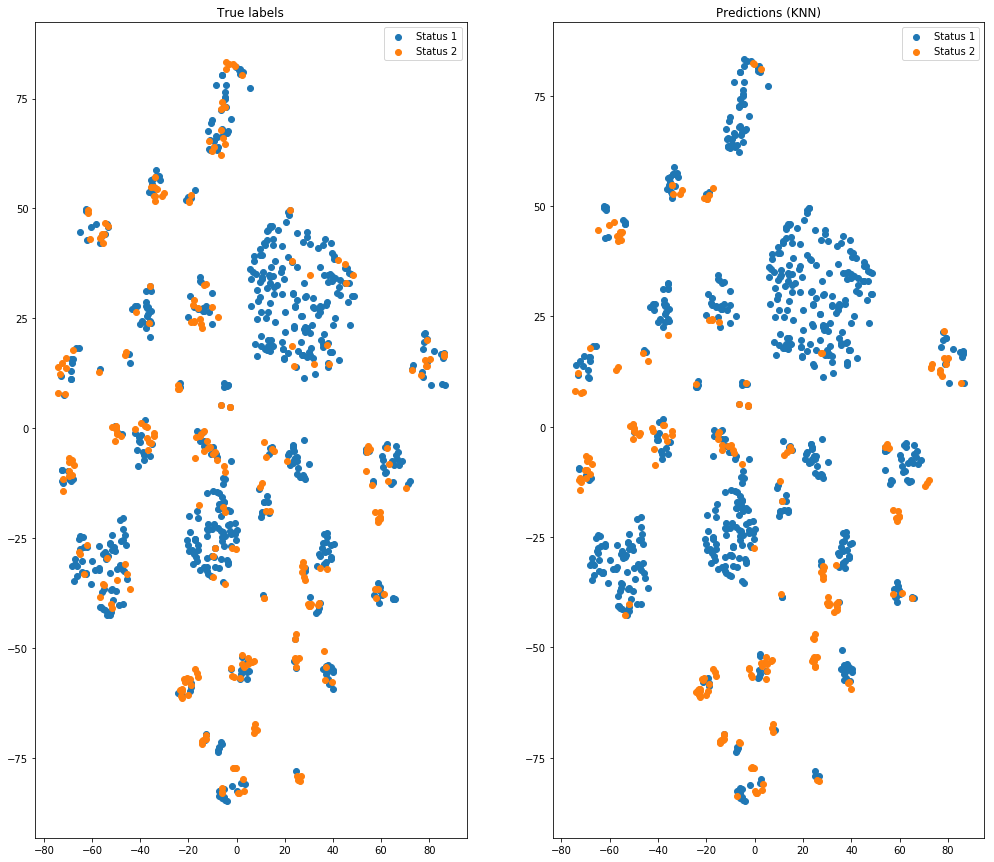

In [45]:
plt.figure(figsize=(17, 15))

plt.subplot(121)
plt.title('True labels')
zeros_idx = np.argwhere(y_test == 1).squeeze() # номера тех объектов, чей статус 1
ones_idx = np.argwhere(y_test == 2).squeeze() # номера тех объектов, чей статус 2
plt.scatter(X_emb_test[zeros_idx, 0], X_emb_test[zeros_idx, 1], label='Status 1')
plt.scatter(X_emb_test[ones_idx, 0], X_emb_test[ones_idx, 1], label='Status 2')
plt.legend()

plt.subplot(122)
plt.title('Predictions (KNN)')
zeros_idx = np.argwhere(y_pred == 1).squeeze() # номера тех объектов, чей статус 1
ones_idx = np.argwhere(y_pred == 2).squeeze() # номера тех объектов, чей статус 2
plt.scatter(X_emb_test[zeros_idx, 0], X_emb_test[zeros_idx, 1], label='Status 1')
plt.scatter(X_emb_test[ones_idx, 0], X_emb_test[ones_idx, 1], label='Status 2')
plt.legend()


**Плюсы:**
* Позволяет визуализировать высокоразмерные (-признаковые) данные
* Возможность получать представление произвольной размерности, необязательно двумерное (n_components=2)
* Сохраняется гипотеза компактности: похожие (близкие) объекты исходного представления остаются близкими в "схлопнутом" низкомерном представлении
* Наличие оптимизированных и распараллеленных [реализаций](https://github.com/DmitryUlyanov/Multicore-TSNE)

**Минусы:**
* ООЧЕНЬ ДООООЛГИЙ (во всяком случае, нераспараллеленная SkLearn'ая версия). Как правило, достаточно нескольких тысяч объектов в выборке, чтобы t-SNE "присел" минут на 10

# Метод главных компонент
Суть метода главных компонент - сжать данные до меньшей размерности, как в t-SNE, оставив только важные закономерности в данных

![](https://habrastorage.org/getpro/habr/post_images/bb6/fe7/f06/bb6fe7f06e114bcc9c354a1cb025b966.png)

На картинке выше стрелочками указаны первые две главные компоненты. Чем длиннее, тем главнее :)

**Достоинства:**
Метод главных компонент похож на t-SNE, но:
* PCA работает НА ПОРЯДКИ быстрее t-SNE
* не требует меток классов (обучение без учителя, требует только X) !

**Недостатки:**
* при сжатии теряется "гипотеза компактности" и объекты часто смешиваются в кучу

**Область применения:**
* Визуализация больших данных
* Упрощение данных
* Кластеризация
* Поиск скрытых компонент в данных. Пример - тематическое моделирование и рекомендации

# Практика



In [55]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from sklearn import decomposition
from sklearn import datasets

np.random.seed(5)

iris = datasets.load_iris()
X = iris.data
y = iris.target

**WARNING!!!** Код визуализации сложный и на практике ненужный, вникать не надо! Цель клетки ниже - визуализировать ирисы по первым трём признакам

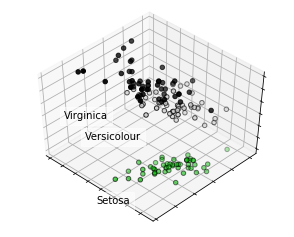

In [56]:
fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.nipy_spectral,
           edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

iris = datasets.load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

# # Скалируем
# for col in X.columns:
#     mms = MinMaxScaler()
#     X[col] = mms.fit_transform(X[[col]])
    
# Выделим из наших данных валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds)))

Accuracy: 0.97778


Теперь попробуем сделать то же самое, но с данными, для которых мы снизили размерность до 2D с помощью PCA

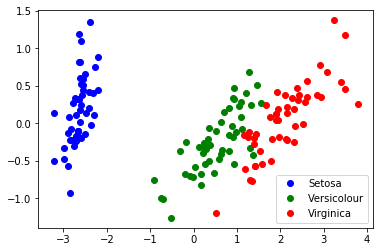

In [58]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Прогоним встроенный в sklearn PCA
pca = PCA(n_components=2)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

# И нарисуем получившиеся точки в нашем новом пространстве
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Setosa')
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'go', label='Versicolour')
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], 'ro', label='Virginica')
plt.legend(loc=0);

In [59]:
from sklearn.model_selection import train_test_split

# Повторим то же самое разбиение на валидацию и тренировочную выборку.
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.95556


Видно, что качество не изменилось, но для более сложных данных более высокой размерности, где данные не разбиваются тривиально вдоль одного признака, применение PCA может достаточно сильно улучшить качество работы деревьев решений и ансамблей на их основе. 

Посмотрим теперь на 2 главные компоненты в последнем PCA-представлении данных и на тот процент исходной дисперсии в даных, который они "объясняют".

In [60]:
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names)))

1 component: 92.46% of initial variance
0.362 x sepal length (cm) + -0.082 x sepal width (cm) + 0.857 x petal length (cm) + 0.359 x petal width (cm)
2 component: 5.3% of initial variance
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.176 x petal length (cm) + -0.075 x petal width (cm)


# Набор данных по рукописным цифрам
Теперь возьмем набор данных по рукописным цифрам

In [61]:
digits = datasets.load_digits()
X, y = digits['data'], digits['target']

Посмотрим, как выглядят эти цифры – посмотрим на первые десять. Картинки здесь представляются матрицей 8 x 8 (интенсивности белого цвета для каждого пикселя). Далее эта матрица "разворачивается" в вектор длины 64, получается признаковое описание объекта.

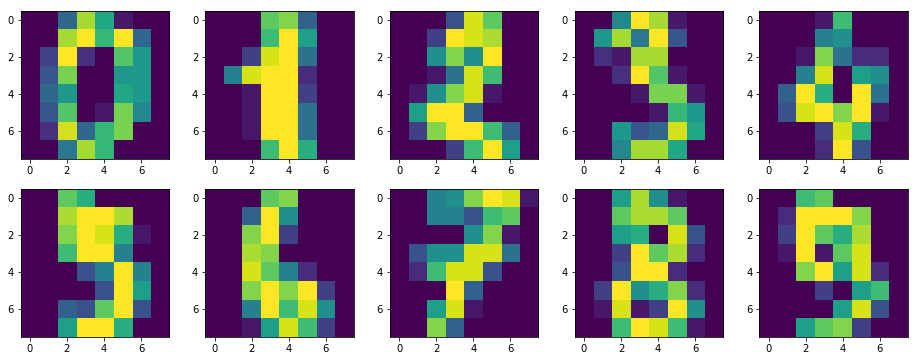

In [62]:
# f, axes = plt.subplots(5, 2, sharey=True, figsize=(16,6))
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]));

Сделаем теперь PCA-разложение

Projecting 64-dimensional data to 2D


Text(0.5,1,'MNIST. PCA projection')

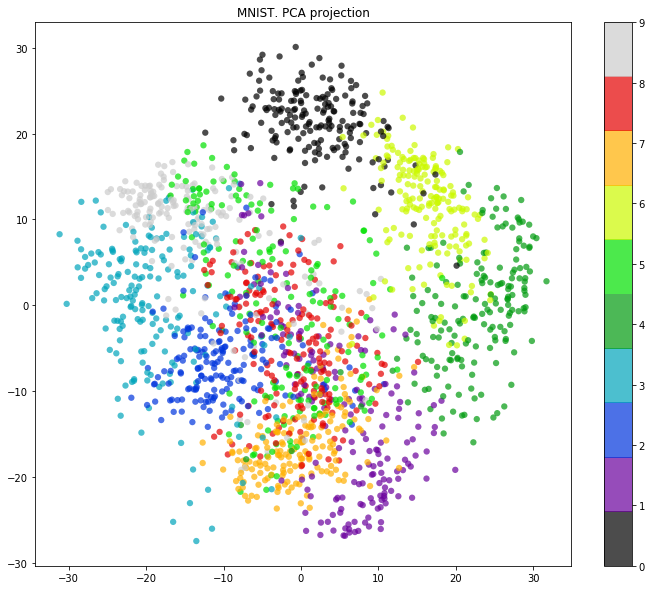

In [63]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection')

Projecting 64-dimensional data to 2D


Text(0.5,1,'MNIST. PCA projection')

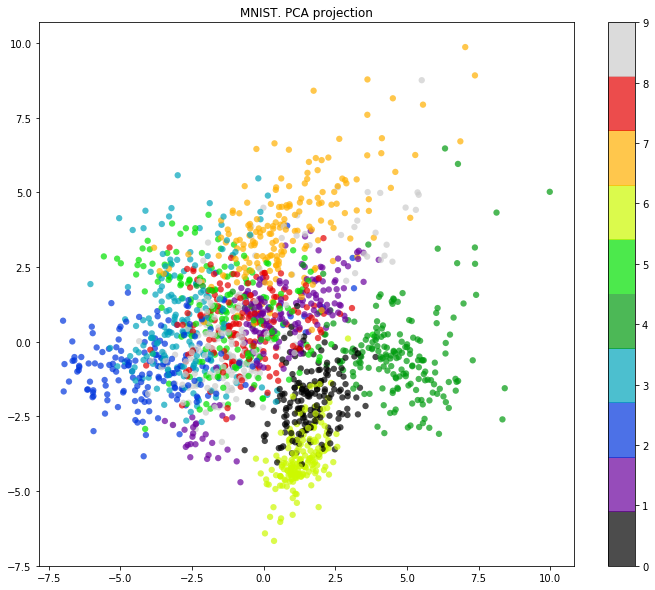

In [75]:
# если стандартизировать
df = pd.DataFrame(digits['data'], columns=range(64))

for col in df.columns:
    ss = StandardScaler()
    df[col] = ss.fit_transform(df[[col]])

pca = PCA(n_components=2)
df_reduced = pca.fit_transform(df)

print('Projecting %d-dimensional data to 2D' % df.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(df_reduced[:, 0], df_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection')

Ну, правда, с t-SNE картинка получается еще лучше, поскольку у PCA ограничение – он находит только линейные комбинации исходных признаков. Зато даже на этом относительно небольшом наборе данных можно заметить, насколько t-SNE дольше работает.

CPU times: user 27.6 s, sys: 2.31 s, total: 29.9 s
Wall time: 29.8 s


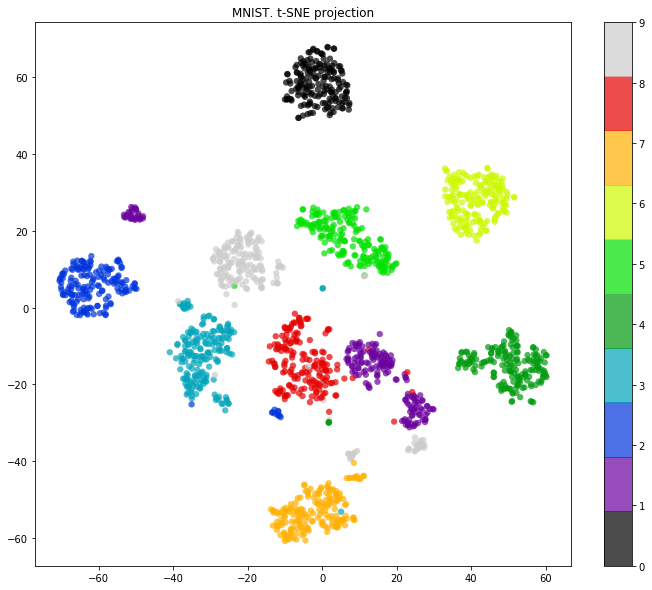

In [16]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection')

CPU times: user 31 s, sys: 2.24 s, total: 33.2 s
Wall time: 33.2 s


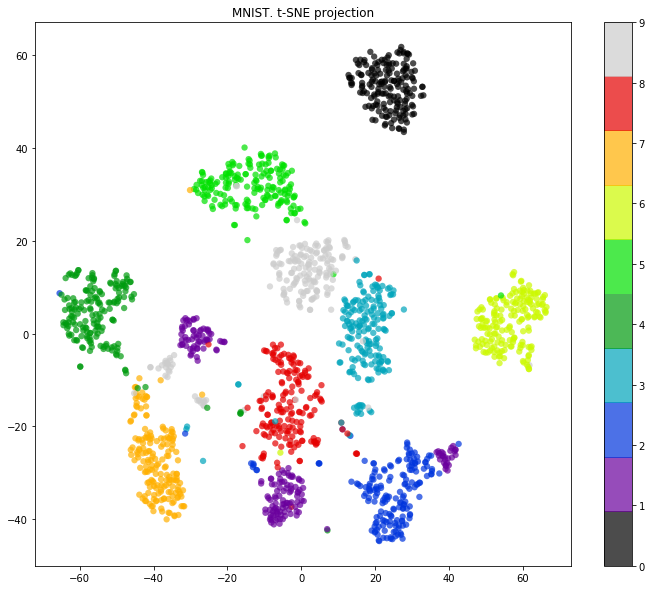

In [76]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(df)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection')

На практике, как правило, выбирают столько главных компонент, чтобы оставить 90% дисперсии исходных данных. В данном случае для этого достаточно выделить 21 главную компоненту, то есть снизить размерность с 64 признаков до 21.

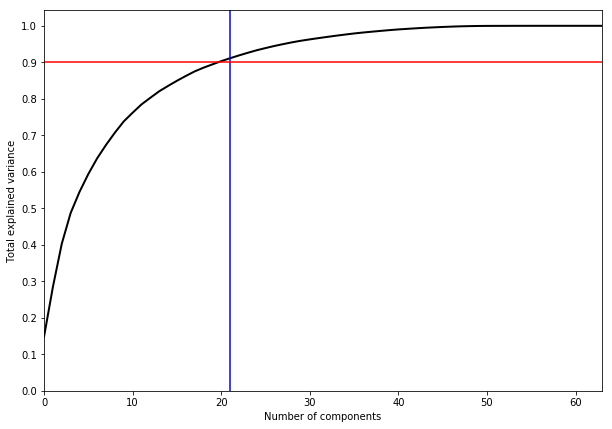

In [19]:
pca = PCA().fit(X)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c='b')
plt.axhline(0.9, c='r')
plt.show();

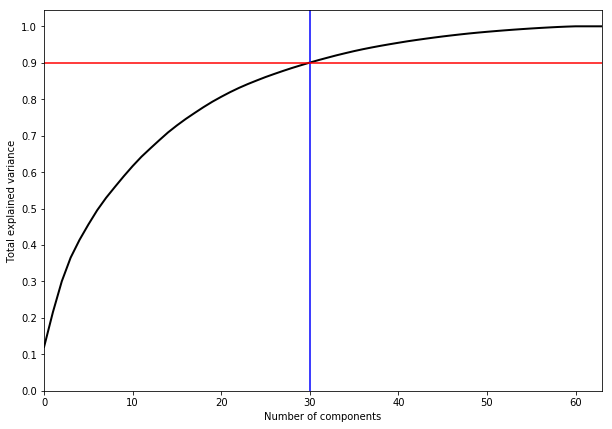

In [78]:
pca = PCA().fit(df)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(30, c='b')
plt.axhline(0.9, c='r')
plt.show();

# Рекомендованная литература
* Хорошая статья про t-SNE на [хабре](https://habr.com/post/267041/)
* [Статья](https://habr.com/post/304214/) про PCA 